In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

Importing the MNIST dataset

In [2]:
from keras.datasets import mnist
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train, _ , y_train , _ = train_test_split(X_train, y_train,train_size=0.5, random_state=6)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape (30000, 784)
y_train shape (30000,)
X_test shape (10000, 784)
y_test shape (10000,)


visualizing the dataset:

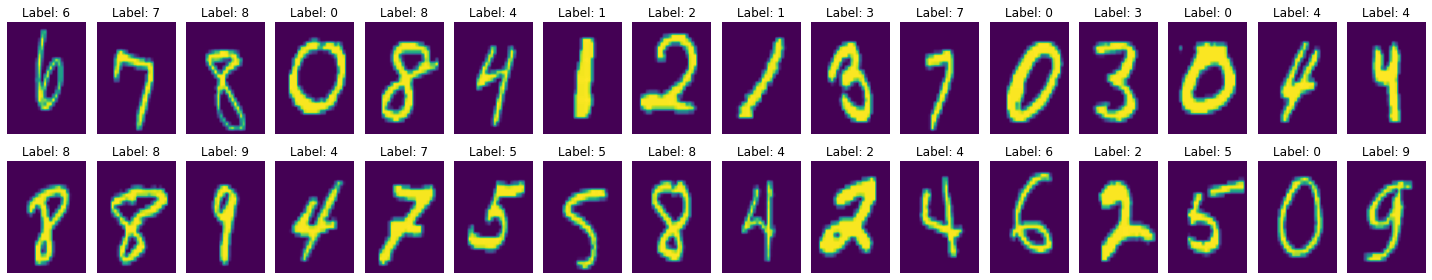

In [ ]:
# Task: Square each element in the primes vector, then subtract 1.

import random
import itertools

test_indices = random.sample(range(X_test.shape[0]), 32)
test_sample = X_test[test_indices]
test_sample_labels = y_test[test_indices]

f, axs = plt.subplots(2, 16)
flattened_axs = itertools.chain(*axs)

for ax, img, label in zip(flattened_axs, test_sample, test_sample_labels):
  ax.axis('off')
  ax.imshow(img.reshape(28,28), aspect='auto')
  ax.set_title(f'Label: {label}')

plt.rcParams["figure.figsize"] = (20,4)
plt.tight_layout()

normalizing the data

In [3]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

pca = PCA()


performing PCA on data

In [5]:
pca.n_components = 100

pca_train = pca.fit_transform(X_train)
print(pca_train.shape)

pca_test = pca.fit_transform(X_test)
print(pca_test.shape)

(30000, 100)
(10000, 100)


   1st_principal  2nd_principal  label
0      12.587427      11.557676    4.0
1       3.011022       1.466285    0.0
2      -7.467864      -1.937013    1.0
3      23.171373      -3.772828    0.0
4      -4.108870      -1.083190    3.0


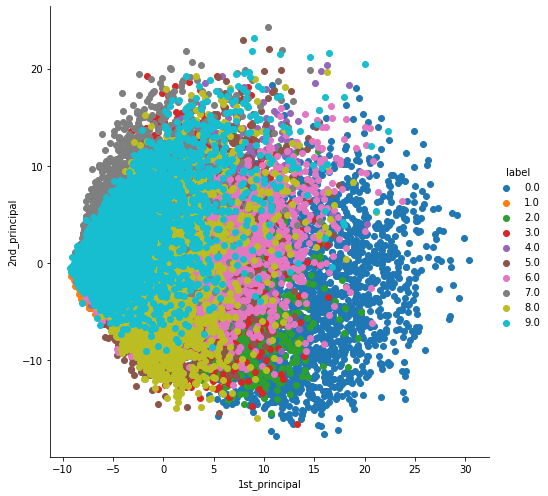

In [ ]:
import seaborn as sn
import pandas as pd

pca_data = np.vstack((pca_train[:,0:2].T,y_train)).T

pca_data = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
print(pca_data.head())

sn.FacetGrid(pca_data,hue='label', height=7).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.show()

Linear Discriminant Analysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(pca_train, y_train)
print('lda score:',lda.score(pca_test, y_test))

lda score: 0.6381


K nearest neighbors cross_validation

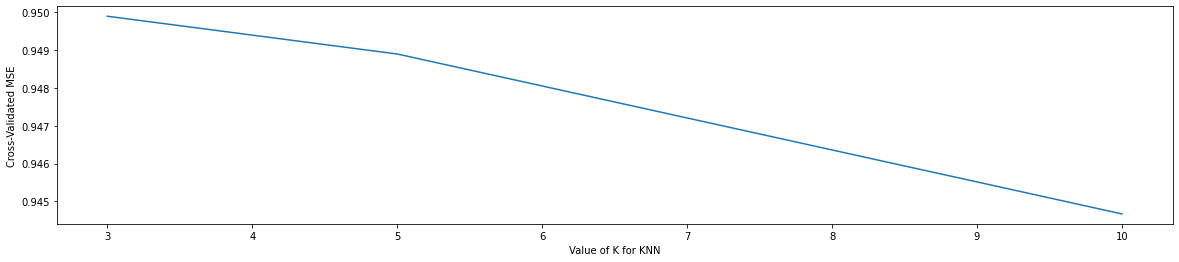

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier as KNN

# performing cross validation to find the optimal K neighbors
_k = [3,5,10]
k_scores = []
for k in _k:
    knn = KNN(n_neighbors=k)
    loss = cross_val_score(knn, pca_train, y_train, cv=5, scoring='accuracy') #5-fold cross validation
    k_scores.append(loss.mean())
plt.plot(_k, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Score')
plt.show()

# Determining the optimal K
optimal_k = (_k[k_scores.index((max(k_scores)))])
print("The optimal number of neighbors is %d" ,% optimal_k)

**Kernel Linear Discriminant Analysis** / Locally Weighted LDA




In [20]:
import numpy as np
import sys

class KLDA():
  
  def __init__(self,X,y,lambda_,kernel,sigma=1):
    """
    Attributes:
        class_names (np.ndarray): array of class names. [0, 1] for example.
        class_priors (dict): prior probability of each class.
            determined via fraction of training samples in each class
        class_means (dict): vector weighted means of each class
        covariances (np.ndarray): weighted class covariance 
    """
    self.class_names = []
    self.class_means = {}
    self.class_priors = {}
    self.covariances = {}
    self.X = X
    self.y = y
    self.kernel = kernel
    self.sigma = sigma
    self.lambda_ = lambda_


  def _kernel(self, x0, x):
    
    if self.kernel== 'epanechnikov':
      t = np.linalg.norm((x - x0)/self.lambda_) / self.sigma
      if t > 1: 
        return 0
      return (0.75 * (1 - t**2))
    
    elif self.kernel == 'tricube':
      t = np.linalg.norm((x - x0)/self.lambda_) / self.sigma
      if t > 1: 
        return 0
      return (1 - t**3)**3
      
    elif self.kernel == 'gaussian':
      t = -np.linalg.norm((x - x0)/self.lambda_)**2 / 2 * (self.sigma**2)
      return np.exp(t)
      
    else:
      print('possible kernels are: epanechnikov, tricube, gaussian')
      sys.exit()


  def _weight(self,x0):

    W = []
    for idx in range(self.X.shape[0]):
      W.append(self._kernel(x0, self.X[idx]))

    return np.asarray(W)


  def fit(self,x0):
    """
    Args:
        X (np.ndarray): Training data of shape[n_samples, n_features]
        y (np.ndarray): Target values of shape[n_samples]
    Returns: an instance of self
    """
    
    W = self._weight(x0)
    
    self.class_names = np.unique(self.y)
    
    # Calculate class priors, class means, covariance matrix
    for i in self.class_names:
      class_indices = np.where(self.y == i)[0]
      class_samples = self.X[class_indices, :]
      class_weights = W[class_indices]
      
      self.class_priors[i] = float(len(class_indices)) / len(self.y)
      self.class_means[i] = np.average(class_samples, axis=0, weights=class_weights)
      self.covariances[i] = np.cov(class_samples, rowvar=0, aweights=class_weights)
        
    return self


  def predict(self, x0):
    """
    Args:
      x (np.array): Training data of shape[1, n_features]
      Currently, only vector of single sample is supported
    Returns: predicted class of sample
    """
    predictions = []
    for inp in x0:
      
      self.fit(inp)
      # Determine probability of each class given input vector
      class_deltas = {}
      for i in self.class_names:

        # Divide the class delta calculation into 3 parts
        part1 = -.5 * np.dot(np.dot(self.class_means[i].T, np.linalg.pinv(self.covariances[i])), self.class_means[i])
        part2 = np.dot(np.dot(inp.T, np.linalg.pinv(self.covariances[i])), self.class_means[i])
        part3 = np.log(self.class_priors[i])

        class_deltas[i] = part1 + part2 + part3
      # print(class_deltas)

      predictions.append(max(class_deltas, key=class_deltas.get))

    return np.asarray(predictions)


  def score(self, predictions, labels):
    s = 0
    for p, l in zip(predictions, labels):
      if not p == l:
        s += 1
    return (1 - (s / len(labels))) * 100

In [23]:
klda = KLDA(pca_train, y_train,lambda_=5, kernel='gaussian')
prediction = klda.predict(pca_test[0:1000,:])
print('klda score:', klda.score(prediction, y_test[0:1000]))


klda score: 8.699999999999996
